In [93]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_79699/1719089161.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [94]:
# establish the dataset
d = 500 # dimension
k = 4 # sparsity
n = 1200 # sample size
K = 400 # number of subgroups
# TODO plot a graph with K as x axis and y as performance
p = 0.1 # corruption probability
mu = np.zeros(d)
mu_sparse = [20, -10, -5, 2]
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))

setting = 'powerlaw'
distribution = 'normal'
X = np.empty((n, d))

match distribution:
    case 'normal':
        # normal distribution
        X = np.random.normal(0, 1, size=(n, d))
    case 'powerlaw':
        # power law distribution
        alpha = 2.5
        xmin = 1
        mean = np.zeros((n, d))
        mean += (alpha / (alpha - 1)) * xmin
        dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
        for i in range(n):
            X[i, :] = dist.generate_random(d)
        X = X - mean


for i in range(k):
    X[:, i] += mu_sparse[i]

# print(np.mean(X, axis=0))

# Add corrupted data
for j in range(np.floor(p * n).astype(int)):
    X[j, :] = 20 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50
# print(np.mean(X, axis=0))

# Grouping preprocessing
X_grouped = np.split(X, K)
X_grouped = np.mean(X_grouped, axis=1)

# print(len(X_grouped))

In [146]:
trial_num = 10
eta = 0.05
rho = 1
max_iter = 600
pred_5 = np.zeros((trial_num, max_iter, d, 1))


for trial in range(trial_num):
    # initialize the parameters
    alpha = 1e-3
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
    
t_min = np.argmin(dists)
# print(error[t_min])
# print(pred[t_min])

In [169]:
pred_5 = np.transpose(pred_5, (0,2,1, 3))
print(pred_5.shape)

(500, 600, 10, 1)


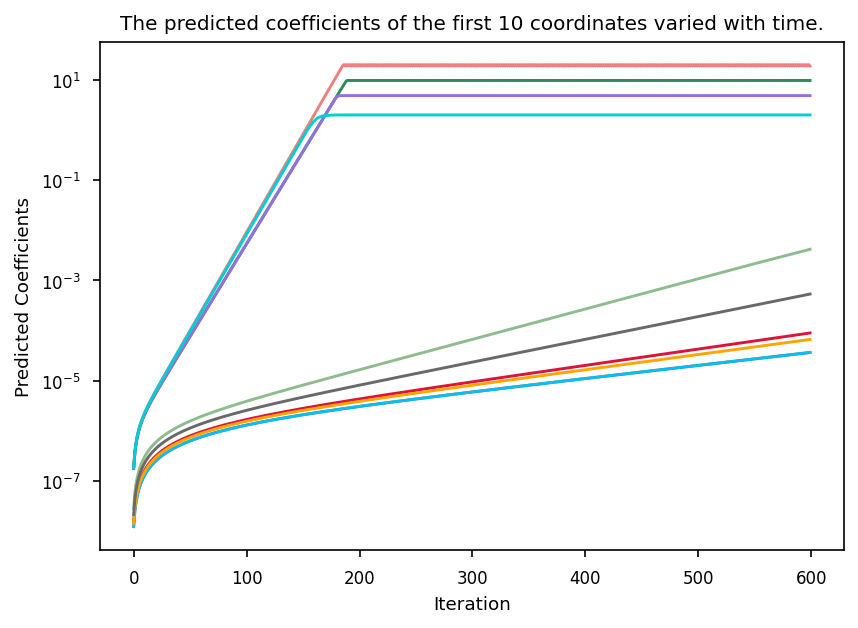

In [197]:
# prediction plots
point_num = 10
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        mins[i][t] = np.sort(pred_5[i][t])[0]
        med[i][t] = np.sort(pred_5[i][t])[trial_num // 2]
        maxs[i][t] = np.sort(pred_5[i][t])[trial_num - 1]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.2)
    plt.plot(med[i], color=col[i])
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

# plt.savefig(f'output/{setting}_pred.png')
plt.show()

In [129]:
error = np.transpose(error, (1, 0, 2))
print(error.shape)
pred = np.transpose(pred, (1, 0, 2))

(500, 600, 1)


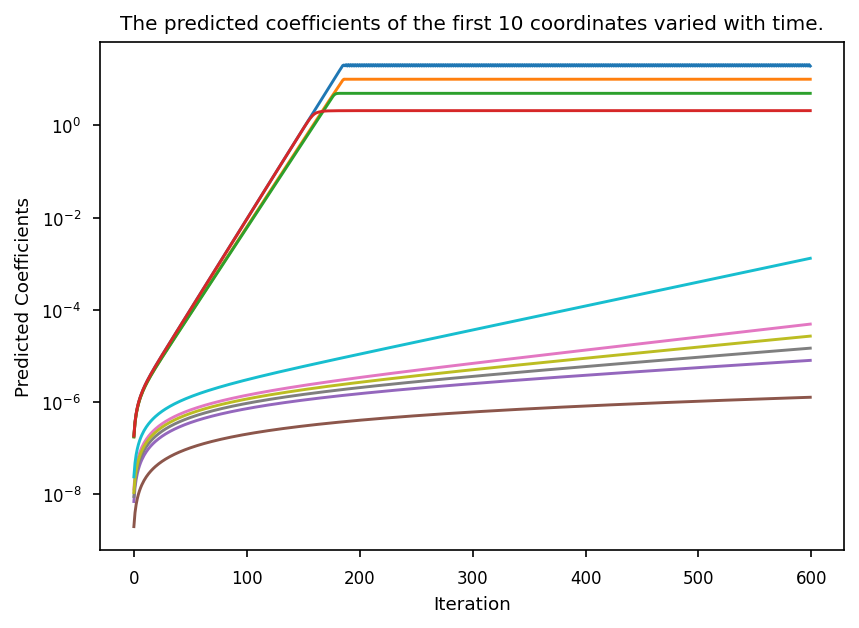

In [ ]:
# prediction plot
point_num = 10
for i in range(point_num):
    plt.plot(pred[i])
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

# plt.savefig(f'output/{setting}_pred.png')
plt.show()

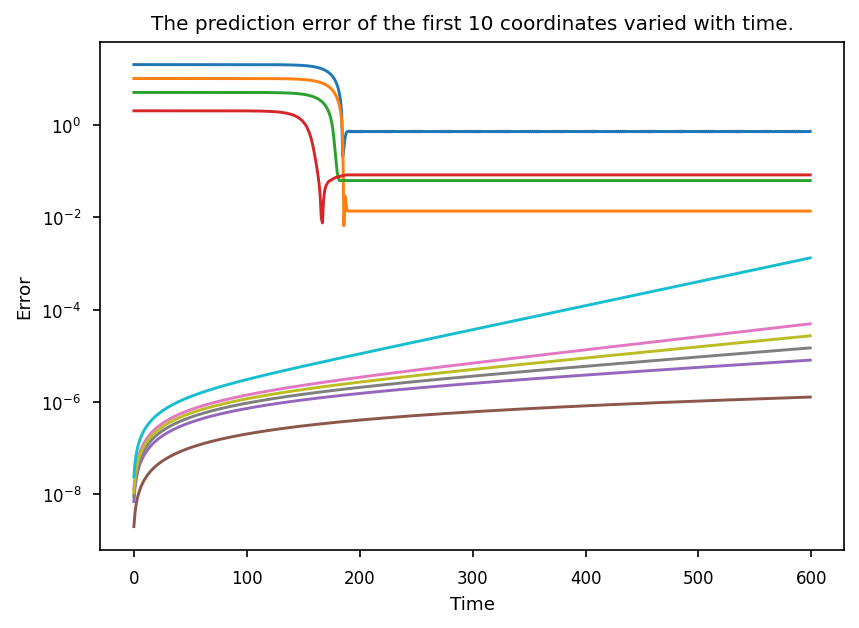

In [ ]:
# error plot
for i in range(point_num):
    plt.plot(error[i])
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel('Time')
plt.title(f'The prediction error of the first {point_num} coordinates varied with time.')

# plt.savefig(f'output/{setting}_error.png')
plt.show()

0.45000783194549127

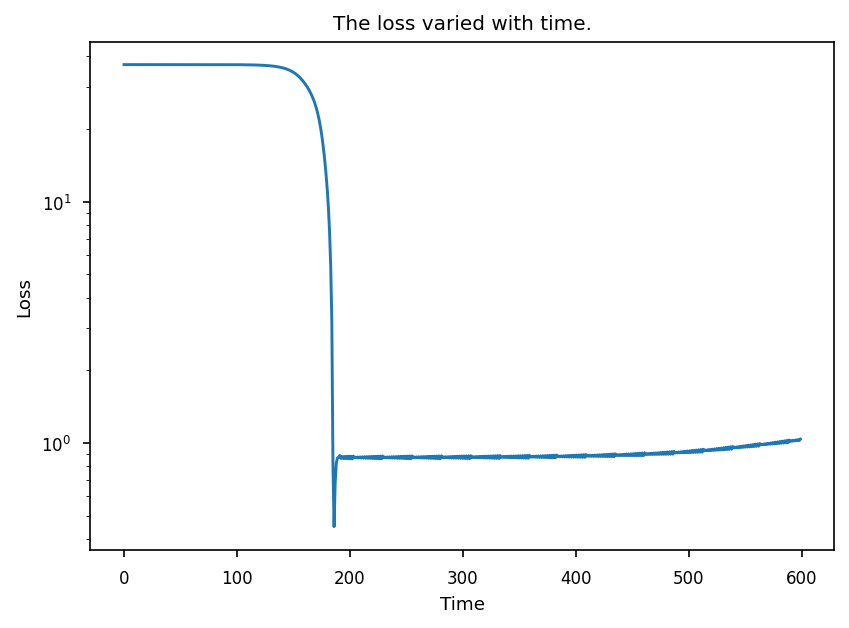

In [ ]:


plt.plot(dists)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Time')
plt.title(f'The loss varied with time.')
# plt.savefig(f'output/{setting}_loss.png')
np.min(dists)

change initialization to np.ones
change K to 400
change p to 0.1

# TODO: compare other algorithms: runtime, l2 loss